This notebook includes **two parts**:
1. **Multi-class classification** using the original `num` target (0–4)
2. **Binary classification** where `0 = No Disease` and `1+ = Any Heart Disease`

We will perform manual preprocessing (no pipelines) and train models accordingly.

---

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import kagglehub

# Set plot style
sns.set_style('whitegrid')

In [19]:
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

file_path = f"{path}/heart_disease_uci.csv"
df = pd.read_csv(file_path)

print("Dataset loaded:", df.shape)
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset loaded: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [20]:
print("Dataset Information:")
df.info()


print("\nDescriptive Statistics:")
print(df.describe())


print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

/tmp/ipython-input-2965680056.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='num', data=df, palette='viridis')


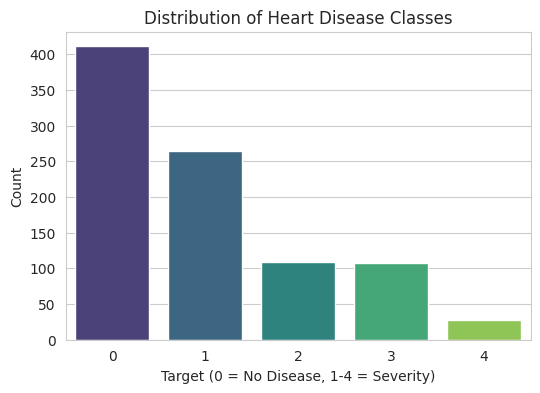

In [21]:
## Step 3: Exploratory Data Analysis (EDA)


# Target distribution (multi-class)
plt.figure(figsize=(6, 4))
sns.countplot(x='num', data=df, palette='viridis')
plt.title('Distribution of Heart Disease Classes')
plt.xlabel('Target (0 = No Disease, 1-4 = Severity)')
plt.ylabel('Count')
plt.show()


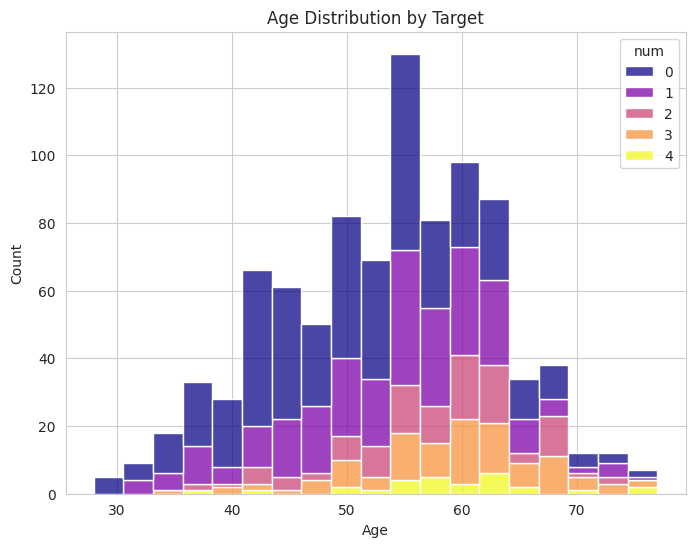

In [22]:
# Age distribution by target
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='age', hue='num', multiple='stack', palette='plasma')
plt.title('Age Distribution by Target')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

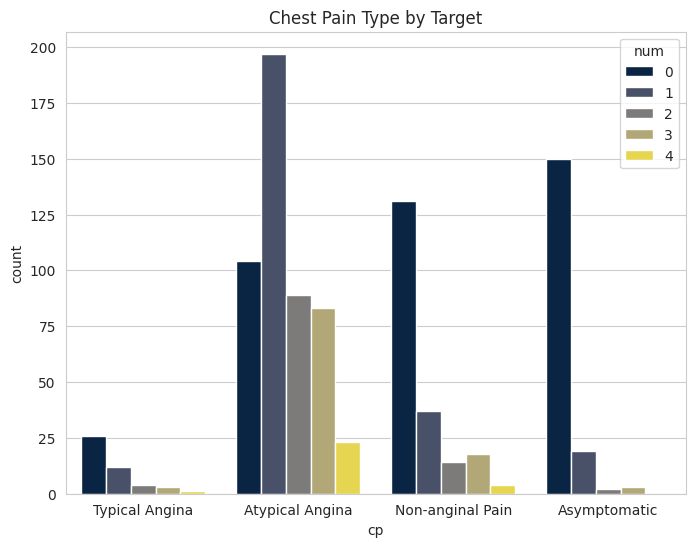

In [23]:
# Chest pain type vs. target
plt.figure(figsize=(8, 6))
cp_plot = sns.countplot(data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])
plt.show()

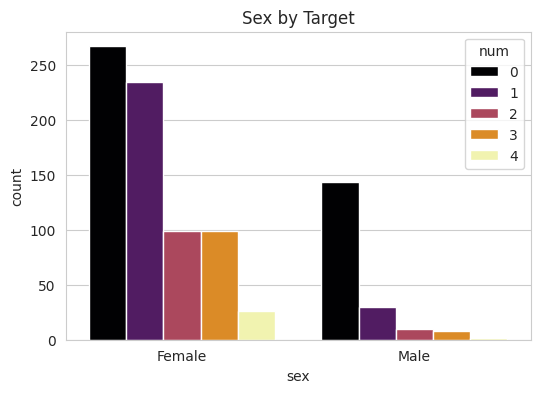

In [24]:
# Sex vs. target
plt.figure(figsize=(6, 4))
sex_plot = sns.countplot(data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])
plt.show()


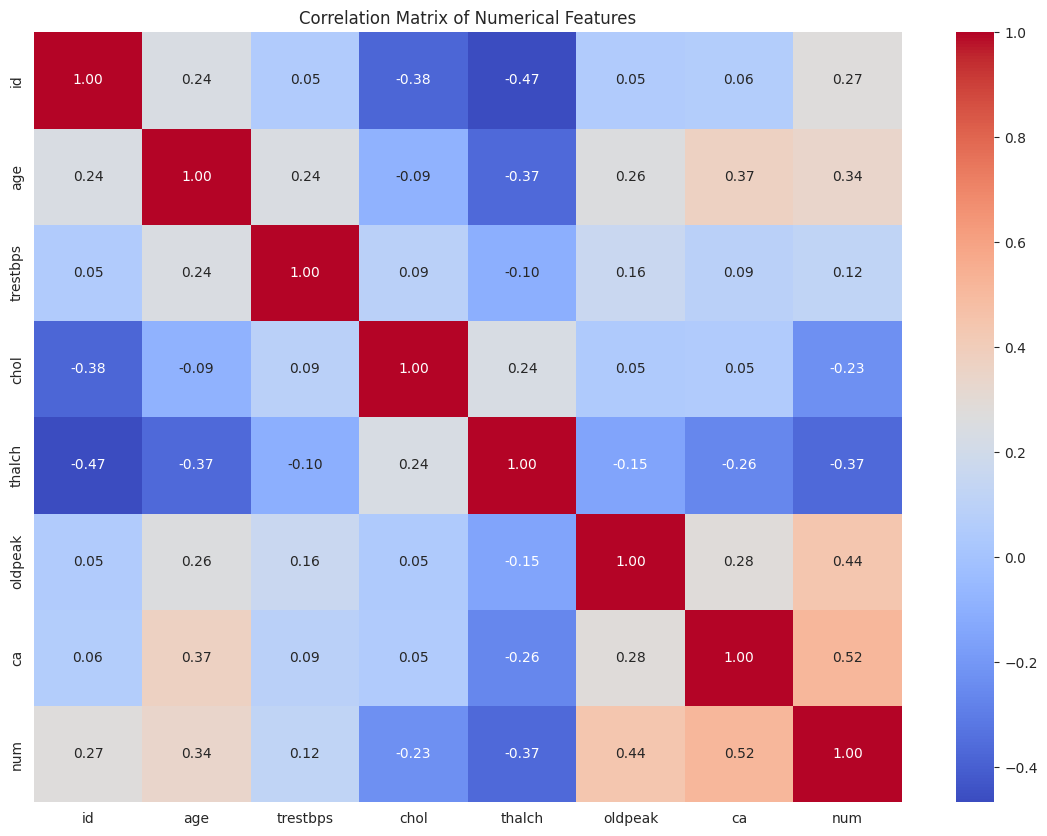

In [25]:
# Correlation heatmap of numerical features
plt.figure(figsize=(14, 10))
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [26]:
X = df.drop(['id', 'dataset', 'num'], axis=1)
y_multi = df['num']  # Original multi-class target

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Impute + scale numerical
imputer_num = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_num = pd.DataFrame(imputer_num.fit_transform(X[numerical_features]), columns=numerical_features)
X_num = pd.DataFrame(scaler.fit_transform(X_num), columns=numerical_features)

# Encode categorical
imputer_cat = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(imputer_cat.fit_transform(X[categorical_features]), columns=categorical_features)
X_cat = pd.get_dummies(X_cat, drop_first=True)

# Final features
X_proc = pd.concat([X_num, X_cat], axis=1)

In [27]:
## Part A: Multi-class Classification (Original num)
X_train, X_test, y_train, y_test = train_test_split(X_proc, y_multi, test_size=0.2, random_state=42, stratify=y_multi)

# Logistic Regression
lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("--- Logistic Regression (Multi-class) ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("--- Random Forest (Multi-class) ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

--- Logistic Regression (Multi-class) ---
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.46      0.57      0.51        53
           2       0.33      0.14      0.19        22
           3       0.23      0.24      0.23        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.37      0.36      0.35       184
weighted avg       0.56      0.59      0.57       184

--- Random Forest (Multi-class) ---
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        82
           1       0.56      0.57      0.56        53
           2       0.12      0.09      0.10        22
           3       0.16      0.14      0.15        21
           4       1.00      0.17      0.29         6

    accuracy                           0.57       184
   macro avg       0.51      0.36      0.38       184

In [28]:
## Part B: Binary Classification (0 vs 1+)
y_bin = (y_multi > 0).astype(int)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_proc, y_bin, test_size=0.2, random_state=42, stratify=y_bin)

# Logistic Regression (Binary)
lr_bin = LogisticRegression(max_iter=2000, random_state=42)
lr_bin.fit(X_train_b, y_train_b)
y_pred_lr_bin = lr_bin.predict(X_test_b)
print("--- Logistic Regression (Binary) ---")
print(classification_report(y_test_b, y_pred_lr_bin, zero_division=0))

# Random Forest (Binary)
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bin.fit(X_train_b, y_train_b)
y_pred_rf_bin = rf_bin.predict(X_test_b)
print("--- Random Forest (Binary) ---")
print(classification_report(y_test_b, y_pred_rf_bin, zero_division=0))

--- Logistic Regression (Binary) ---
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        82
           1       0.83      0.87      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184

--- Random Forest (Binary) ---
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        82
           1       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



/tmp/ipython-input-1064982302.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


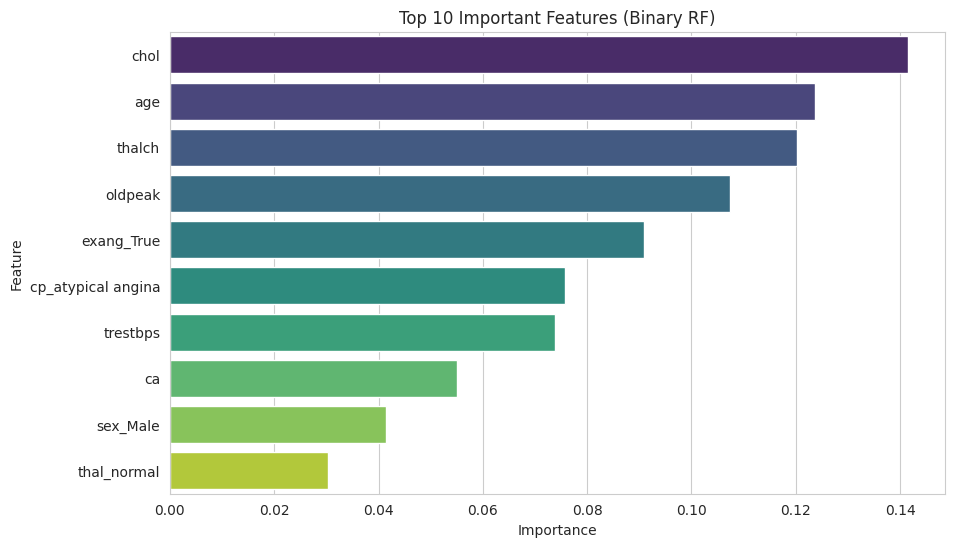

In [29]:
## Step 5: Feature Importance (from Random Forest)
importances = rf_bin.feature_importances_
feature_names = X_proc.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Important Features (Binary RF)')
plt.show()

## Conclusion
- **Multi-class classification** gave us insights into severity (0–4), though models struggled with minority classes.
- **Binary classification (0 vs 1+)** simplified the task and showed stronger metrics, especially with Random Forest.
- Important features: **ca, thalch, cp, thal** remain the most influential predictors.
